In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from PIL import Image, ImageDraw, ImageFont

In [3]:
font_dirs = ['fonts']
font_extensions = ['ttf', 'otf', 'ttc']

def is_fontfile(full_path):
    extension_dot = full_path.rfind('.')
    return (extension_dot != -1) and \
           (full_path[extension_dot + 1 :] in font_extensions)

In [4]:
alphabet = list('АБВГҐДЕЄЖЗИІЇЙКЛМНОПРСТУФХЦЧШЩЬЮЯабвгґдеєжзиіїйклмнопрстуфхцчшщьюя1234567890№%@,.?:;"!()-\'')
np.array(alphabet)

array(['А', 'Б', 'В', 'Г', 'Ґ', 'Д', 'Е', 'Є', 'Ж', 'З', 'И', 'І', 'Ї',
       'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х',
       'Ц', 'Ч', 'Ш', 'Щ', 'Ь', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'ґ', 'д',
       'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о',
       'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ю',
       'я', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '№', '%',
       '@', ',', '.', '?', ':', ';', '"', '!', '(', ')', '-', "'"],
      dtype='<U1')

In [5]:
font_files = []

for fdir in font_dirs:
    for dirname, dirnames, filenames in os.walk(fdir):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)

            if is_fontfile(full_path):
                font_files.append(full_path)
                
font_files[:5]

['fonts\\AA-BebasNeue.ttf',
 'fonts\\AA-Higherup.ttf',
 'fonts\\Academy.ttf',
 'fonts\\AcademyCTT_Bold.ttf',
 'fonts\\AcademyCTT_Italic.ttf']

In [6]:
def font_name(full_path):
    # Font name is between the last '/' and the last '.' symbols
    # Example:
    #     full path: '/usr/share/fonts/truetype/msttcorefonts/Courier_New_Bold_Italic.ttf'
    #     font name: 'Courier_New_Bold_Italic'
    return full_path[full_path.rfind('/') + 1 : full_path.rfind('.')]

# This will allow the font_name function to convert the whole
# vectors (arrays) of full pathes to font names
# font_name = np.vectorize(font_name)

# font_name(font_files)[100:110]

In [9]:
import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter

background_color = 0
fill_color = 255

def char_to_image(char, font_file, img_size, min_scale=0.6, max_scale=1):
    # Генеруємо випадковий масштабний фактор
    scale_factor = random.uniform(min_scale, max_scale)
    
    font_size = int(img_size * 0.9 * scale_factor)
    
    img = Image.new('L', (img_size, img_size), background_color)
    drawer = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_file, font_size) 
    
    # Get character width and height  
    (font_width, font_height) = font.getsize(char)
  
    x = (img_size - font_width) / 2   
    y = (img_size - font_height) / 2  

    drawer.text((x, y), char, fill_color, font=font)
    
    return add_blur(img)

def add_blur(image, blur_size=(5, 5), blur_sigma=0):
    # Конвертація зображення з PIL до OpenCV формату
    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    
    # Застосування гаусового блюру
    blurred_image = cv2.GaussianBlur(open_cv_image, blur_size, blur_sigma)
    
    # Конвертація зображення назад до PIL формату
    image = Image.fromarray(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))

    return image

# Зразок зображення з випадковою аугментацією розміру
augmented_image = char_to_image('A', font_files[40], 32)

# Перевірка
augmented_image.show()

C:\Users\vvlad\AppData\Local\Temp\ipykernel_26524\664269955.py:19: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'GaussianBlur'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


Same letter, different fonts

C:\Users\vvlad\AppData\Local\Temp\ipykernel_24820\2535252526.py:18: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


Letter 1: о
Letter 2: Є


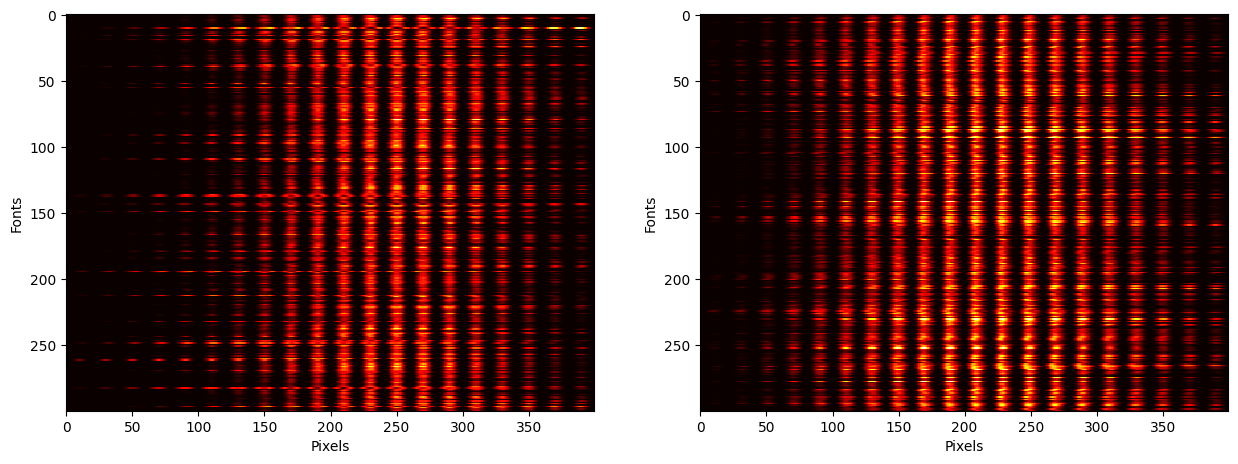

In [7]:
i = [np.random.randint(0, len(alphabet)) for _ in range(2)]

imgs = [[], []]

for _ in range(300):
    j = [np.random.randint(0, len(font_files)) for _ in range(2)]
    
    imgs[0].append(np.array(char_to_image(alphabet[i[0]], font_files[j[0]], 20)).reshape(400))
    imgs[1].append(np.array(char_to_image(alphabet[i[1]], font_files[j[1]], 20)).reshape(400))

pylab.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

subplots = []

for k in range(2):
    subplots.append(fig.add_subplot(1,2,k+1))
    subplots[k].set_xlabel('Pixels')
    subplots[k].set_ylabel('Fonts')
    subplots[k].imshow(imgs[k], cmap='hot', interpolation='none')

print('Letter 1:', alphabet[i[0]])
print('Letter 2:', alphabet[i[1]])

C:\Users\vvlad\AppData\Local\Temp\ipykernel_24820\2535252526.py:18: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


Font 1: fonts\LiberationMono-BoldItalic
Font 2: fonts\DejaVuSansMono-Bold


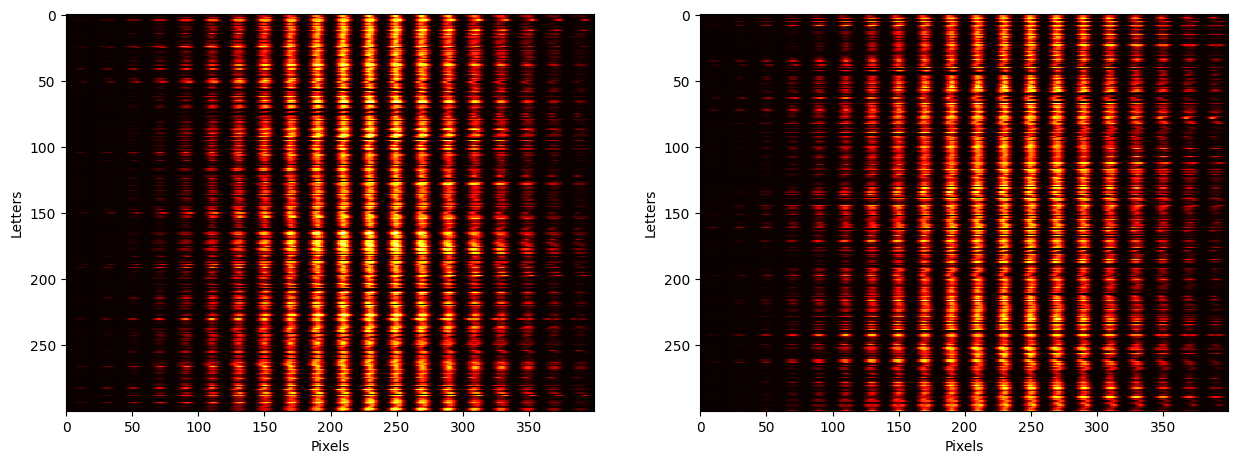

In [8]:
j = [np.random.randint(0, len(font_files)) for _ in range(2)]

imgs = [[], []]

for _ in range(300):
    i = [np.random.randint(0, len(alphabet)) for _ in range(2)]
    
    imgs[0].append(np.array(char_to_image(alphabet[i[0]], font_files[j[0]], 20)).reshape(400))
    imgs[1].append(np.array(char_to_image(alphabet[i[1]], font_files[j[1]], 20)).reshape(400))

pylab.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

subplots = []

for k in range(2):
    subplots.append(fig.add_subplot(1,2,k+1))
    subplots[k].set_xlabel('Pixels')
    subplots[k].set_ylabel('Letters')
    subplots[k].imshow(imgs[k], cmap='hot', interpolation='none')

print('Font 1:', font_name(font_files[j[0]]))
print('Font 2:', font_name(font_files[j[1]]))

In [9]:
im_size = 32

v = []

for i in range(len(alphabet)):
    for font_file in font_files:
        for j in range(10):  # Цикл для створення 10 зображень з різними розмірами
            im = np.array(char_to_image(alphabet[i], font_file, im_size)).flatten()
            im_with_label = np.hstack((i, im))
            v.append(im_with_label)

C:\Users\vvlad\AppData\Local\Temp\ipykernel_24820\2535252526.py:18: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  (font_width, font_height) = font.getsize(char)


In [ ]:
import json

df = pd.DataFrame(v)
df = df.sample(frac=1)



In [ ]:
df.to_csv('uaset_extended_with_scale_factor_and_blure.csv', index=False)